In [1]:
!pip install openfermion
!pip install openfermionpyscf

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.1 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=29070df2c282f26297b08f1af1f56b2ccf9d7952383da25326515a5a7d101940
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 13.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import openfermion as of
from scipy import linalg
from scipy.linalg import expm
import matplotlib.pyplot as plt
from openfermion.chem import MolecularData

from openfermion.transforms import (
    get_fermion_operator,
    jordan_wigner)
from openfermionpyscf import run_pyscf
from openfermion.linalg import LinearQubitOperator

from tqdm.notebook import tqdm

## H4 molecule

In [3]:
multiplicity = 1
basis = "sto-3g"

h1, h2, h3, h4 = 0, 0.735, 1.535, 2.135


geometry = [('H', (0., 0., h1)), ('H', (0., 0., h2)),('H', (0., 0., h3)),('H', (0., 0., h4))]


description = "h4"
molecule = MolecularData(geometry, basis, multiplicity, description=description)
molecule = run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)

In [4]:
molHam = molecule.get_molecular_hamiltonian()

fermionHam = get_fermion_operator(molHam)

H = jordan_wigner(fermionHam)


print('Number of qubits:', LinearQubitOperator(H).n_qubits)

Number of qubits: 8


In [5]:
# some helper functions

def channel(H, t, rho):
    #return expm(1.j*H*t).dot(rho).dot(expm(-1.j*H*t))
    return expm(1.j*H*t) @ rho @ expm(-1.j*H*t)

def trace_norm(A):
    return .5*sum(linalg.svdvals(A)) # same as np.linalg.norm(A, ord=2)

# qDRIFT Algorithm

In [ ]:
# qDRIFT algorithm

def qDRIFT(n, H, t, eps, rho0):

    L = len(H.terms)

    h = [list(H.terms.values())[j] for j in range(L)]

    lam = sum(np.abs(h))

    H_list = [list(H)[j]/abs(h[j]) for j in range(L)]

    N = int(2 * lam**2 * t**2 / eps)

    print('lambda:', lam, 'N:', N)

    rho = rho0

    tau = lam * t / N

    for j in tqdm(range(N)):

        local_H = np.random.choice(H_list, p = np.abs(h)/lam)

        local_H_mtx = of.get_sparse_operator(local_H,n).toarray()

        rho = channel(local_H_mtx, tau, rho)

    return rho

In [6]:
# Let's check qDRIFT for simple case. Inital state is the completely mixed state.

n = 8
rho0 = (1/2**n)*np.ones((2**n,2**n))
eps = 0.01
t=1

In [ ]:
rho_qdrift = qDRIFT(n, H, t, eps, rho0)

lambda: 10.614937998461802 N: 22535


  0%|          | 0/22535 [00:00<?, ?it/s]

In [7]:
H_mtx = of.get_sparse_operator(H,n).toarray()

In [ ]:
rho_exact = channel(H_mtx, t, rho0)

rho_qdrift_error = rho_exact - rho_qdrift

qdrift_error = trace_norm(rho_qdrift_error)

print('qDRIFT error:', qdrift_error)

qDRIFT error: 0.055244423676344176


# 2nd Order Linear qDRIFT (Simplified)

In [ ]:
def commutator(A, B):
    return A @ B - B @ A

def secondOrderLinearQDrift(n, H, t, eps, rho0, num_steps):
    """
    Second-order channel method for approximating time evolution over t.

    Parameters:
    - n: Num qubits.
    - H: Hamiltonian (QubitOperator).
    - t: Total time for the evolution.
    - eps: Desired error (epsilon)
    - rho0: Initial density matrix.
    - num_steps: Number of time steps in the evolution.

    Returns:
    - rho: Density matrix after applying the second-order channel over t.
    """
    # Usual setup
    L = len(H.terms)
    h = [list(H.terms.values())[j] for j in range(L)]
    lam = sum(np.abs(h))
    H_list = [list(H)[j]/abs(h[j]) for j in range(L)]

    N = int(2 * lam**2 * t**2 / eps)
    print('lambda:', lam, 'N:', N)
    tau = lam * t / N
    p = np.abs(h)/lam

    # qDRIFT evolution for num_steps * tau time
    print('short-time qDRIFT evolution')

    rho_qDRIFT = rho0
    for s in tqdm(range(num_steps)):
        rho_qDRIFT = sum(p[i]*channel(of.get_sparse_operator(H_list[i],n).toarray(), tau, rho_qDRIFT) for i in range(L))

    # Second order Linear qDRIFT evolution for num_steps * tau time
    print('short-time 2nd order Linear qDRIFT evolution')

    rho = rho0
    # Loop over num_steps for the evolution
    for _ in tqdm(range(num_steps), desc="Applying second-order channel"):

        # 2nd order correction
        corr = sum(
            p[j] * of.get_sparse_operator(H_list[j], n).toarray() @ rho @
            of.get_sparse_operator(H_list[j], n).toarray()
            for j in range(L)
        )

        # First part: the probabilistic mix of Hamiltonian channels (rho_E1)
        H_total = of.get_sparse_operator(H, n).toarray()

        rho_E1_k = sum(p[k]*channel(of.get_sparse_operator(
                                      H_list[k],n).toarray(), tau, rho)
                                  for k in range(L))
        rho_E1 = sum(p[j]*channel(of.get_sparse_operator(H_list[j],n).toarray(),
                                  tau, rho_E1_k) for j in range(L))

        # Second part: the second-order correction (rho_E2)
        rho_E2 = corr

        # Combine them according to the corrected formula
        rho = 0.5 * (1 + 2 * tau**2) * rho + 0.5 * rho_E1 - tau**2 * rho_E2

    rho_secondorder_linear_qDRIFT = rho

    return rho_qDRIFT, rho_secondorder_linear_qDRIFT

## Comparing errors for one step

In [ ]:
rho_qDRIFT_oneStep, rho_secondorder_linear_qDRIFT_oneStep = secondOrderLinearQDrift(n, H, t, eps, rho0, 1)

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/1 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
L = len(H.terms)

h = [list(H.terms.values())[j] for j in range(L)]

lam = sum(np.abs(h))

tau = t/int(2 * lam**2 * t**2 / eps)

rho_exact_oneStep = channel(H_mtx, tau, rho0)

qDrift_error_oneStep = trace_norm(rho_exact_oneStep - rho_qDRIFT_oneStep)

secondorder_linear_qDrift_error_oneStep = trace_norm(rho_exact_oneStep - rho_secondorder_linear_qDRIFT_oneStep)

print('One step error for qDRIFT', qDrift_error_oneStep)
print('One step error for 2nd order linear qDRIFT', secondorder_linear_qDrift_error_oneStep)

One step error for qDRIFT 1.9970850345267752e-07
One step error for 2nd order linear qDRIFT 2.7910281337218925e-11


## Comparing errors for 10 steps

In [ ]:
rho_qDRIFT_tenStep, rho_secondorder_linear_qDRIFT_tenStep = secondOrderLinearQDrift(n, H, t, eps, rho0, 10)

lambda: 10.614937998461802 N: 22535
short-time qDRIFT evolution


  0%|          | 0/10 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
L = len(H.terms)

h = [list(H.terms.values())[j] for j in range(L)]

lam = sum(np.abs(h))

tau = t/int(2 * lam**2 * t**2 / eps)

rho_exact_tenStep = channel(H_mtx, 10*tau, rho0)

qDrift_error_tenStep = trace_norm(rho_exact_tenStep - rho_qDRIFT_tenStep)

secondorder_linear_qDrift_error_tenStep = trace_norm(rho_exact_tenStep - rho_secondorder_linear_qDRIFT_tenStep)

print('10 step error for qDRIFT', qDrift_error_tenStep)
print('10 step error for 2nd order linear qDRIFT', secondorder_linear_qDrift_error_tenStep)

10 step error for qDRIFT 1.9970831943121686e-06
10 step error for 2nd order linear qDRIFT 2.9862571175659855e-12


## Plotting 1 to 10 step error

In [ ]:
L = len(H.terms)

h = [list(H.terms.values())[j] for j in range(L)]

lam = sum(np.abs(h))

tau = t/int(2 * lam**2 * t**2 / eps)
qdrift_errors = []
secondorder_onestep_errors = []
for i in range(10):
  rho_qDRIFT_oneStep, rho_secondorder_linear_qDRIFT_oneStep = secondOrderLinearQDrift(n, H, t, eps, rho0, i+1)

  rho_exact_oneStep = channel(H_mtx, (i+1)*tau, rho0)

  qDrift_error_oneStep = trace_norm(rho_exact_oneStep - rho_qDRIFT_oneStep)

  secondorder_linear_qDrift_error_oneStep = trace_norm(rho_exact_oneStep - rho_secondorder_linear_qDRIFT_oneStep)

  qdrift_errors.append(qDrift_error_oneStep)

  secondorder_onestep_errors.append(secondorder_linear_qDrift_error_oneStep)

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/1 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/1 [00:00<?, ?it/s]

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/2 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/2 [00:00<?, ?it/s]

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/3 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/3 [00:00<?, ?it/s]

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/4 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/4 [00:00<?, ?it/s]

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/5 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/5 [00:00<?, ?it/s]

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/6 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/6 [00:00<?, ?it/s]

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/7 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/7 [00:00<?, ?it/s]

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/8 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/8 [00:00<?, ?it/s]

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/9 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/9 [00:00<?, ?it/s]

lambda: 10.614937998461809 N: 22535
short-time qDRIFT evolution


  0%|          | 0/10 [00:00<?, ?it/s]

short-time 2nd order Linear qDRIFT evolution


Applying second-order channel:   0%|          | 0/10 [00:00<?, ?it/s]

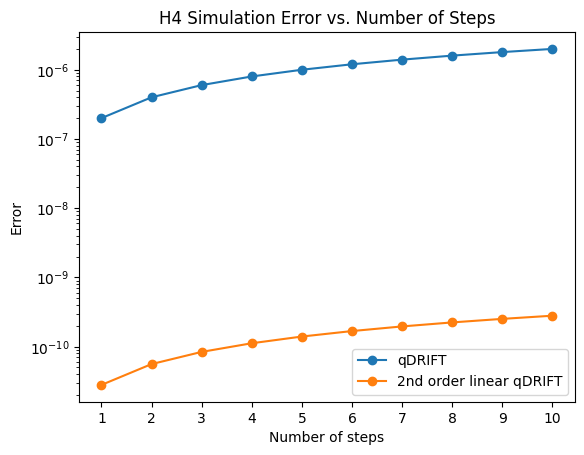

In [ ]:
# print(qdrift_errors)
# print(secondorder_onestep_errors)

# From previous run of simulation
qdrift_errors = [1.9970850345267752e-07, 3.994169652318141e-07, 5.99125386422057e-07, 7.988337668080712e-07, 9.985421064145662e-07, 1.1982504052164004e-06, 1.397958663270496e-06, 1.5976668805639165e-06, 1.7973750571348356e-06, 1.9970831929321516e-06]
secondorder_onestep_errors = [2.7910281337218925e-11, 5.582053951223892e-11, 8.373080808848817e-11, 1.1164109036571229e-10, 1.395513834887626e-10, 1.674616969083939e-10, 1.9537202452654182e-10, 2.232823510888331e-10, 2.511926900773014e-10, 2.791030174582599e-10]


plt.figure(1)
plt.plot(range(1, 11), qdrift_errors, label='qDRIFT', marker='o')
plt.plot(range(1, 11), secondorder_onestep_errors, label='2nd order linear qDRIFT', marker='o')
plt.xlabel('Number of steps')
plt.ylabel('Error')
plt.xticks(range(1, 11))
plt.legend()
plt.yscale("log")
plt.title("H4 Simulation Error vs. Number of Steps")
plt.show()

# 2nd Order Linear qDRIFT (Direct approach, randomized)

In [8]:
def commutator(A, B):
    return A @ B - B @ A

def corr(H, rho):
    return H @ rho @ H

def secondOrderLinearQDrift(n, H, t, eps, rho0):
    """
    Second-order channel method for approximating time evolution over t.

    Parameters:
    - n: Num qubits.
    - H: Hamiltonian (QubitOperator).
    - t: Total time for the evolution.
    - eps: Desired error (epsilon)
    - rho0: Initial density matrix.
    - num_steps: Number of time steps in the evolution.

    Returns:
    - rho: Density matrix after applying the second-order channel over t.
    """
    # Usual setup
    L = len(H.terms)

    h = [list(H.terms.values())[j] for j in range(L)]

    lam = sum(np.abs(h))

    H_list = [list(H)[j]/abs(h[j]) for j in range(L)]

    N = int(2 * lam**(1 + 1/2) * t**(1 + 1/2) / eps**(1/2))

    print('lambda:', lam, 'N:', N)

    tau = lam * t / N

    p = np.abs(h)/lam

    rho = rho0
    # Loop over N for the evolution
    for _ in tqdm(range(N), desc="Applying second-order channel"):

        j = np.random.choice(range(len(H_list)), p = p)
        local_H_j = H_list[j]

        k = np.random.choice(range(len(H_list)), p = p)
        local_H_k = H_list[k]

        local_H_mtx_j = of.get_sparse_operator(local_H_j,n).toarray()
        local_H_mtx_k = of.get_sparse_operator(local_H_k,n).toarray()

        # First part: the probabilistic mix of Hamiltonian channels (rho_E1)
        rho_E1 = channel(local_H_mtx_k, tau, channel(local_H_mtx_j, tau, rho))

        # Second part: the second-order correction (rho_E2)
        rho_E2 = corr(local_H_mtx_j, rho)

        # Combine them according to the corrected formula
        rho = 0.5 * (1 + 2 * tau**2) * rho + 0.5 * rho_E1 - tau**2 * rho_E2

    return rho

In [9]:
# Let's check for simple case. Inital state is the completely mixed state.

n = 8
rho0 = (1/2**n)*np.ones((2**n,2**n))
eps = 0.01
t=1

In [10]:
rho_secondorder = secondOrderLinearQDrift(n, H, t, eps, rho0)

lambda: 10.614937998461809 N: 691


Applying second-order channel:   0%|          | 0/691 [00:00<?, ?it/s]

In [ ]:
H_mtx = of.get_sparse_operator(H,n).toarray()

In [11]:
rho_exact = channel(H_mtx, t, rho0)

rho_secondorder_error = rho_exact - rho_secondorder

secondorder_error = trace_norm(rho_secondorder_error)

print('2nd order error:', secondorder_error)

2nd order error: 0.3242336627596622


## Average error (10 iterations)

In [ ]:
# Run it k times, get average error

def avg_secondorder_error(k):
  avg_secondorder_error = 0

  for i in tqdm(range(k)):
    rho_secondorder = secondOrderLinearQDrift(n, H, t, eps, rho0)

    rho_exact = channel(H_mtx, t, rho0)

    rho_secondorder_error = rho_exact - rho_secondorder

    secondorder_error = trace_norm(rho_secondorder_error)

    avg_secondorder_error += secondorder_error

  avg_secondorder_error /= k
  print(f'Average 2nd order error ({k} times):', avg_secondorder_error)

avg_secondorder_error(10)

# 2nd Order Linear qDRIFT Implementation (One Step at a Time)

In [ ]:
def secondorder_channel(H_j, H_k, tau, psi):
    # Defining the rotation matrix
    alpha = 1/np.sqrt(1 + 2*tau**2)
    R = np.array([[1, tau*np.sqrt(2)], [-tau*np.sqrt(2), 1]])*alpha

    # Defining Kraus operators
    U_1 = expm(-1.j*H_j*t)*expm(-1.j*H_k*t)
    U_2 = H_j
    Id_n = np.eye(n)

    A_0 = Id_n
    A_1 = U_1
    A_2 = tau*np.sqrt(2)*U_2
    A_3 = tau*np.sqrt(2)*Id_n

    # Add 3 ancilla qubits
    ket_0 = np.array[1,0]
    ancillas_psi = np.kron(ket_0, np.kron(ket_0, np.kron(ket_0, psi)))

In [ ]:
def secondOrderLinearQDrift(n, H, t, eps, rho0):
    """
    Second-order channel method for approximating time evolution over t.

    Parameters:
    - n: Num qubits.
    - H: Hamiltonian (QubitOperator).
    - t: Total time for the evolution.
    - eps: Desired error (epsilon)
    - rho0: Initial density matrix.
    - num_steps: Number of time steps in the evolution.

    Returns:
    - rho: Density matrix after applying the second-order channel over t.
    """
    # Usual setup
    L = len(H.terms)

    h = [list(H.terms.values())[j] for j in range(L)]

    lam = sum(np.abs(h))

    H_list = [list(H)[j]/abs(h[j]) for j in range(L)]

    N = int(2 * lam**(1 + 1/2) * t**(1 + 1/2) / eps**(1/2))

    print('lambda:', lam, 'N:', N)

    tau = lam * t / N

    p = np.abs(h)/lam

    rho = rho0
    # Loop over N for the evolution
    for _ in tqdm(range(N), desc="Applying second-order channel"):

        j = np.random.choice(range(len(H_list)), p = p)
        local_H_j = H_list[j]

        k = np.random.choice(range(len(H_list)), p = p)
        local_H_k = H_list[k]

        local_H_mtx_j = of.get_sparse_operator(local_H_j,n).toarray()
        local_H_mtx_k = of.get_sparse_operator(local_H_k,n).toarray()

        rho = secondorder_channel(local_H_mtx_j, local_H_mtx_k, tau, rho0)

    return rho